### Classification: Binary Classifier, Using the MNIST Example

#### Content Includes:
- Stochastic Gradient Descent (SGD) classifier
- Stratified sampling
- ROC and AUC
- Confusion Matrix

This notebook is my learning journal following the book:
Hands-On Machine Learning with
Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly).
Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.

#### Load data

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
# Import dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

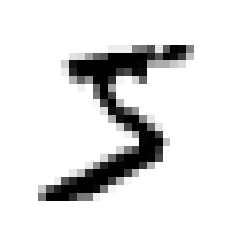

In [4]:
# Load the first number
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
# Set test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# Make test binary (whether or not the picture is 5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### Stochastic Gradient Descent (SGD) classifier
SGD handles very large datasets efficiently. This is in part because SGD deals with training instances independently. The SGDClassifier relies on randomness during training (hence the name “stochastic”).

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

The StratifiedKFold class performs stratified sampling (as explained in Chapter 2 - Hands-on ML book)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [15]:
skfolds = StratifiedKFold(n_splits=3, random_state=42);
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\tduan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()

In [18]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(
    sgd_clf, 
    X_train, 
    y_train_5, 
    cv=3,
    method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

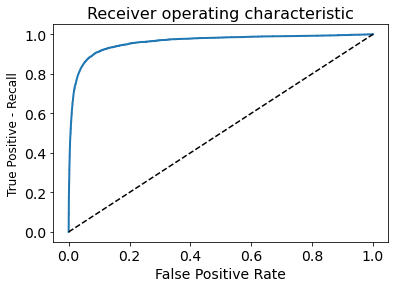

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid
    plt.title('Receiver operating characteristic',fontsize=16)
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive - Recall',fontsize=12)
    plt.tick_params(axis='both',labelsize=14)

plot_roc_curve(fpr, tpr)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### Now compare it with RF classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [25]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

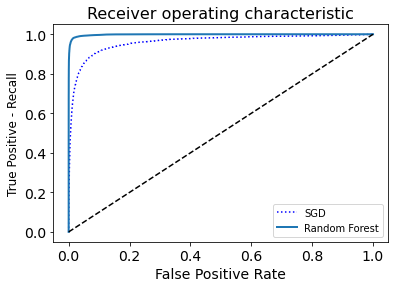

In [26]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic',fontsize=16)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive - Recall',fontsize=12)
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145